# DSC180A Causal Discovery of Remote Work and Mental Health
group members: Evelyn, Vivan, Jason, Yishan

In [1]:
!pip install causal-learn
!pip install --upgrade matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Setup

In [2]:
import numpy as np
import pandas as pd
from causallearn.search.ConstraintBased.PC import pc
import matplotlib.pyplot as plt
import networkx as n
import seaborn as sns

##  Data simulation

In [3]:
import numpy as np
import pandas as pd

# Seed the simulation for reproducibility
np.random.seed(0)
n = 5000

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Independent and confounding variables
education_level = np.random.choice(['high_school', 'bachelor', 'master', 'doctorate'], size=n)
extroverted = np.random.choice([0, 1], size=n)  # 0 for introverted, 1 for extroverted

# Define education effect based on education level
education_map = {'high_school': 1, 'bachelor': 2, 'master': 3, 'doctorate': 4}
education_effect = np.array([education_map[edu] for edu in education_level])

# Adjust average daily work hours based on education level
average_daily_work_hours = np.clip(8 + np.random.normal(0, 1, size=n) + education_effect, 0, 16)

# Adjust family member number based on education level
family_member_number = np.clip(2 + np.random.poisson(1, size=n) - education_effect, 0, 10)

# Influence of extroverted on exercise level and social interaction
exercise_level = np.clip(2 + np.random.normal(0, 1, size=n) + extroverted, 0, 4)

# Simulate other variables
company_support_for_mental_support = np.random.randint(1, 6, size=n)

# Work location influenced by company mental support
p_remote = sigmoid((company_support_for_mental_support - 3) * 0.5)
work_location = np.where(
    np.random.rand(n) < p_remote,
    np.random.choice(['remote', 'hybrid'], size=n, p=[0.6, 0.4]),
    'onsite'
)

# Social Isolation Rating influenced by family members and work location, moderated by extroversion
social_isolation_base = np.where(
    work_location == 'remote',
    3 + np.random.normal(0, 0.5, size=n),
    np.where(
        work_location == 'hybrid',
        2 + np.random.normal(0, 0.5, size=n),
        1 + np.random.normal(0, 0.5, size=n)
    )
)
social_isolation_rating = np.clip(social_isolation_base + np.log1p(family_member_number) - extroverted, 1, 5)

# Sleep Quality influenced by work hours and exercise
sleep_quality = np.clip(2 - np.power((average_daily_work_hours / 10), 2) + exercise_level, 0, 4)

# Stress Level influenced by social isolation (cubic relationship)
stress_level = np.clip(np.power(social_isolation_rating, 3) / 27 + (4 - sleep_quality) + np.random.normal(0, 0.5, size=n), 1, 10)

# Compile results into a DataFrame
data = {
    "Family_Members": family_member_number,
    "Company_Support": company_support_for_mental_support,
    "Work_Location": work_location,
    "Social_Isolation_Rating": social_isolation_rating,
    "Sleep": sleep_quality,
    "Stress_Level": stress_level,
    "Education_Level": education_level,
    "Extroverted": extroverted,
    "Exercise_Level": exercise_level,
    "Average_Daily_Work_Hours": average_daily_work_hours
}

data = pd.DataFrame(data)

In [4]:
#convert categorical columns to numerical labels
data['Work_Location'] = data['Work_Location'].map({'onsite': 1, 'hybrid': 2, 'remote': 3})
data["Education_Level"] = pd.Series(education_level).map({'high_school': 1, 'bachelor': 2, 'master': 3, 'doctorate': 4}).values

In [5]:
data

,Family_Members,Company_Support,Work_Location,Social_Isolation_Rating,Sleep,Stress_Level,Education_Level,Extroverted,Exercise_Level,Average_Daily_Work_Hours
0,1,4,1,1.000000,4.000000,1.000000,1,1,4.000000,7.578096
1,0,2,1,1.000000,1.169698,2.223155,4,0,0.393816,11.063991
2,1,1,1,1.000000,3.477512,1.000000,2,1,2.438587,9.803443
3,3,1,1,1.000000,3.614454,1.000000,1,1,2.324262,8.425012
4,0,3,3,3.293175,3.241105,2.404578,4,0,2.866853,12.750483
...,...,...,...,...,...,...,...,...,...,...
4995,1,4,2,2.356483,2.559473,2.006536,4,0,2.145069,12.592046
4996,0,5,1,1.000000,4.000000,1.000000,2,1,4.000000,10.009057
4997,0,1,2,1.384344,1.494679,2.502712,4,0,0.729818,11.113678
4998,3,3,1,1.000000,4.000000,1.000000,2,1,3.289979,10.049100


In [6]:
data.to_csv('data.csv', index=False)

# EDA for association

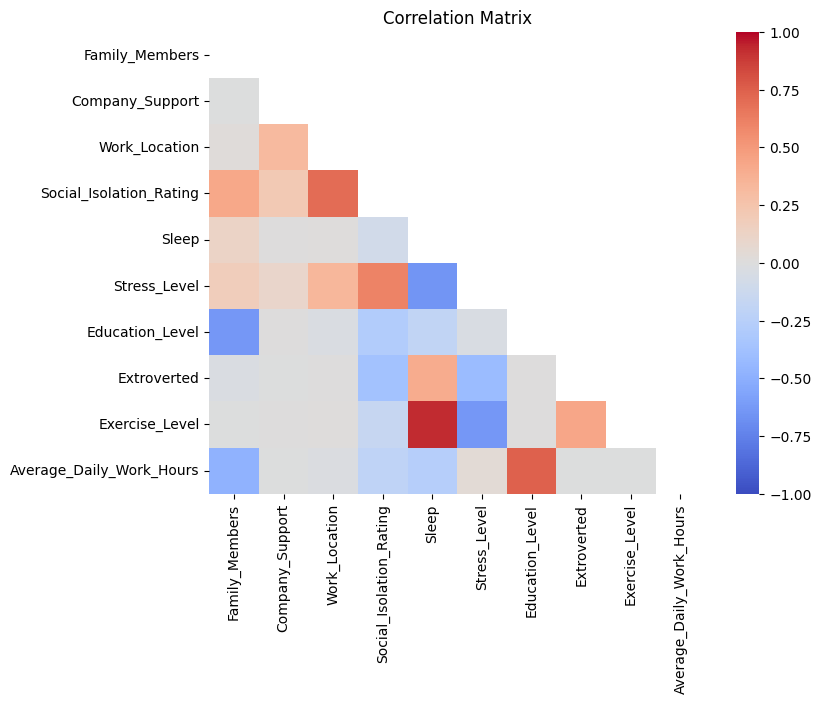

In [7]:
correlation_matrix = data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Algorithm

## PC algorithm

In [8]:
new_data = data.drop(columns = {'Education_Level', 'Extroverted'}, axis = 1)
new_data

,Family_Members,Company_Support,Work_Location,Social_Isolation_Rating,Sleep,Stress_Level,Exercise_Level,Average_Daily_Work_Hours
0,1,4,1,1.000000,4.000000,1.000000,4.000000,7.578096
1,0,2,1,1.000000,1.169698,2.223155,0.393816,11.063991
2,1,1,1,1.000000,3.477512,1.000000,2.438587,9.803443
3,3,1,1,1.000000,3.614454,1.000000,2.324262,8.425012
4,0,3,3,3.293175,3.241105,2.404578,2.866853,12.750483
...,...,...,...,...,...,...,...,...
4995,1,4,2,2.356483,2.559473,2.006536,2.145069,12.592046
4996,0,5,1,1.000000,4.000000,1.000000,4.000000,10.009057
4997,0,1,2,1.384344,1.494679,2.502712,0.729818,11.113678
4998,3,3,1,1.000000,4.000000,1.000000,3.289979,10.049100


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Green: undirected; Blue: directed; Red: bi-directed



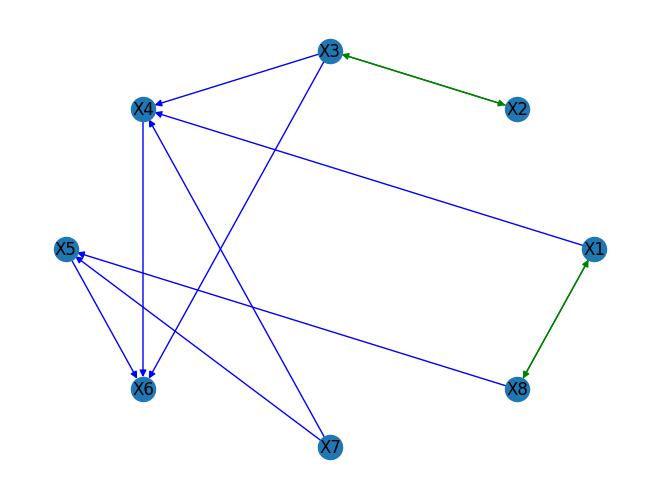

In [9]:
from causallearn.search.ConstraintBased.PC import pc

# Define default or example values for parameters
alpha = 0.05  # Common threshold for independence testing
indep_test = "fisherz"  # Typically 'fisherz' for continuous data
stable = True  # Whether to use a stable version of the algorithm
uc_rule = 0  # Unshielded collider discovery rule (0, 1, or 2; try default 0 first)
uc_priority = False  # Unshielded collider priority; default False
mvpc = False  # Missing values in PC algorithm, default False
correction_name = None  # Name of correction for independence tests; default None
background_knowledge = None  # Optional prior knowledge to guide the algorithm
verbose = False  # Whether to print additional info during execution
show_progress = True  # Show progress in long runs

# default parameters
cg = pc(new_data.values)

# or customized parameters
cg = pc(new_data.values, alpha, indep_test, stable, uc_rule, uc_priority, mvpc, correction_name, background_knowledge, verbose, show_progress)

# visualization using pydot
#cg.draw_pydot_graph()

# or save the graph
#from causallearn.utils.GraphUtils import GraphUtils

#pyd = GraphUtils.to_pydot(cg.G)
#pyd.write_png('simple_test.png')

# visualization using networkx
cg.to_nx_graph()
cg.draw_nx_graph(skel=False)

In [10]:
new_data.columns

Index(['Family_Members', 'Company_Support', 'Work_Location',
       'Social_Isolation_Rating', 'Sleep', 'Stress_Level', 'Exercise_Level',
       'Average_Daily_Work_Hours'],
      dtype='object')